# Gradients and Color Spaces
---
## Gradient Threshold
Canny edge detection to find pixcels that were likely to be part of a line in an image. Canny is great a finding all possible lines in an image. But for lane detection, this gave us a lot of edges on scenery, cars, and other objects that we ended up discarding. Realistically, with lane finding, we know ahead of time that the lines we are looking for are close to vertical. So, how can we take advantage of that fact?
We can use gradients in a smarter way to detect steep edges that are more likely to be lanes in the first place. With Canny, we were actually taking a derivertive with respect to X and Y in the process of finding edges.

But let's have a look at what those individual derivatives look like for an image of the road.

---
### Sobel Operator
The Sobel Operator is at the heart of the Canny edge detection algorithm. Applying the Sobel operator to an image is a way of taking the derivartive of the image in the x or y direction.

           -1  0  1
    Sx = ( -2  0  2 )
           -1  0  1
           
           -1 -2 -1-
    Sy = (  0  0  0  )
            1  2  1
         
These are examples of Sobel operators with a kernel size of 3 (kernel size must be any odd number). A larger kernel implies taking the gradient over a larger region of the image, or, in other words, a smoother gradient. Taking the gradient in the x direction emphasizes edges closer to vertical. Alternatively, taking the gradient in the y direction emphasizes edges closet to horizontal.

**To calculate the gradients** I can use these operators and convolve some region (part of an image).
    
    gradient = Σ(region * Sx)
    
    if region given:

               2  2  2 
    region = ( 2  2  2 )
               2  2  2
               
    gradiant will be zero.

---
**cv2.Sobel()**

Calculate the derivertive of a image (with single color channel).
##### Parameters
 - p1: single color channel image (might be gray scaled image)

##### Returns

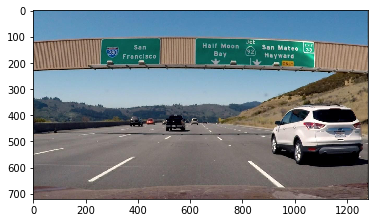

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('images/signs_vehicles_xygrad.png')
plt.imshow(image)

In [41]:
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max = 100):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    absolute = np.absolute(sobel)
    scaled_sobel = np.uint8(absolute*255/np.max(absolute))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1
    return binary

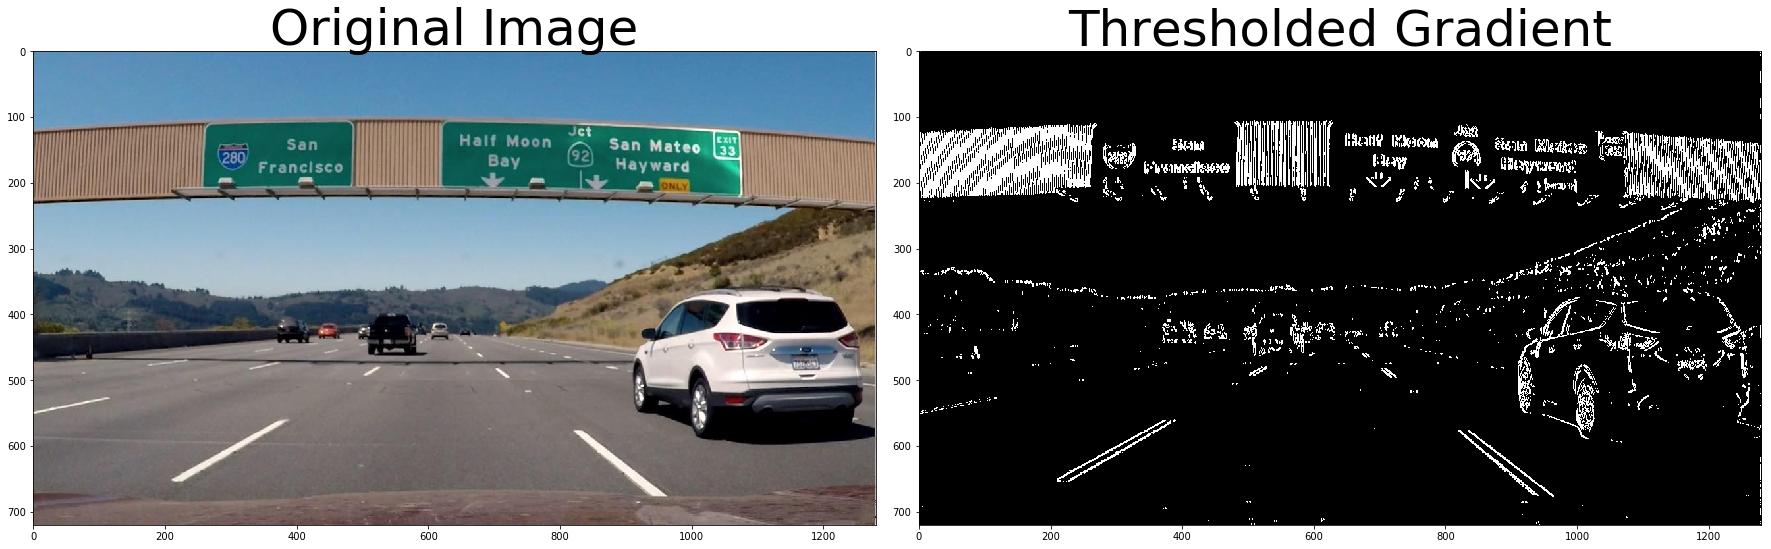

In [42]:
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
### Magnitude of the Gradient
Now I can take the gradient in x or y and set thresholds to identify pixels within a certain gradient range. And found:
 - x-gradient does a cleaner job of picking up the lane lines.
 - y-gradient make the lines more clearly.
Next learning is to apply a threshold to the overall magnitude(absolute) of the gradient, in both x and y.
The magnitude of the gradient is just the square root of the squares of the individual x and y gradients. For a gradient in both the x and y directions, the magnitude is the square root of the sum of the squares.

    abs_sobelx = sqrt(sobelx^2)
    
    abs_sobely = sqrt(sobely^2)
    
    abs_sobelxy = sqrt(sobelx^2 + sobely^2)　（絶対値とは「０からどれだけ離れているか」なので、x-y平面におけるある点(x,y)の絶対値を知りたければ、三角関数を用いればよくこちらの式が導かれる。）
    
It's also worth considering the size of the region in the image over which I'll be taking the gradient(kernel size). Taking the gradient over larger regions can smooth over noisy intensity fluctuations on small scales.

In [43]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    normalized = np.uint8(gradmag*255/np.max(gradmag))
    binary = np.zeros_like(normalized)
    binary[(normalized > mag_thresh[0]) & (normalized < mag_thresh[1])] = 1
    return binary

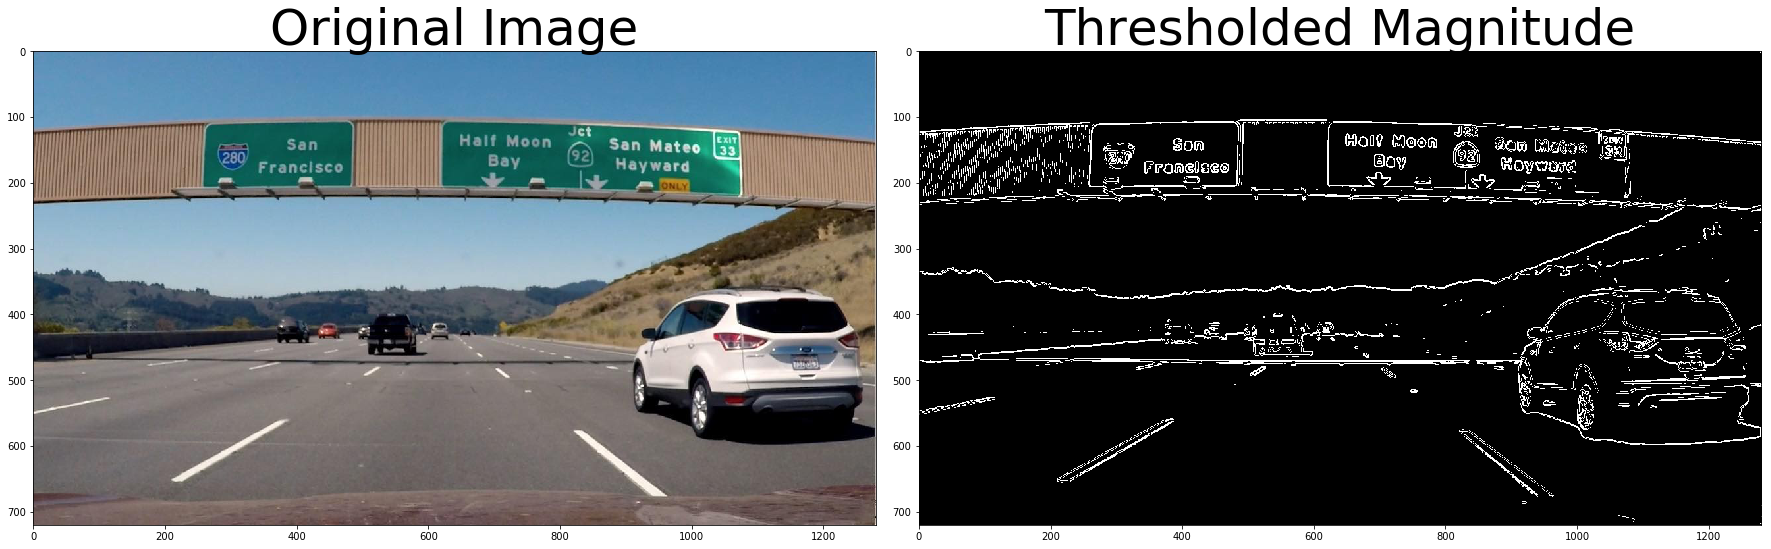

In [45]:
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)